# Numba implementation of greedy search

Allow just-in-time compilation with numba.

## Test data

As test data we generate simple binary random matrices $R \in \{0, 1\}^{m \times n}$ with a fixed proportion of 1-entries ($\alpha=0.5$) for a range of $n$ and $m$ values.

In [3]:
import numpy as np
import pandas as pd

RNG = np.random.default_rng(seed=0)

In [4]:
def rand_array(size, alpha=0.2):
    n, k = size
    d = np.arange(n*k)
    RNG.shuffle(d)
    d = (d < alpha*len(d)).astype(int)
    return d.reshape(n, k)

In [5]:
d_tiny = rand_array((10, 5), alpha=0.5)
d_tiny

array([[1, 1, 0, 1, 1],
       [1, 0, 1, 1, 0],
       [1, 1, 0, 1, 1],
       [0, 0, 0, 1, 1],
       [0, 1, 0, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 1, 1],
       [1, 0, 0, 1, 1],
       [0, 0, 0, 1, 0]])

In [6]:
ns = np.arange(5, 51, 5)
ms = np.arange(50, 501, 50)

alpha = 0.5

d = {}
for m in ms:
    for n in ns:
        X = rand_array((m, n), alpha=alpha)
        true_weights = RNG.random(n) * 10
        y = X @ true_weights + RNG.random(m)
        y = np.sign(y - y.mean())
        dfX = pd.DataFrame(data=X, index=None, columns=[f'x{i}' for i in range(X.shape[1])])
        dfy = pd.Series(data=y)
        d[(m, n)] = (dfX, dfy)

## Existing implementation

In [7]:
from realkd.rules import RuleBoostingEstimator, XGBRuleEstimator, logistic_loss

re = RuleBoostingEstimator(base_learner=XGBRuleEstimator(loss=logistic_loss, search='greedy'))

def re_fit(data):
  re.fit(data[0], data[1])

In [8]:
t_bm = {}

for i in ms:
    t_bm[(i, ns[0])] = %timeit -o re_fit(d[(i, ns[0])])

for i in ns:
    t_bm[(ms[0], i)] = %timeit -o re_fit(d[(ms[0], i)])

763 ns ± 80.5 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
739 ns ± 24.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
731 ns ± 41.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
711 ns ± 39.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
747 ns ± 55.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
728 ns ± 44.4 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
755 ns ± 65.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
725 ns ± 30.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
705 ns ± 21 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
727 ns ± 26.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
814 ns ± 86.5 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
832 ns ± 91.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
816 ns ± 79.4 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
9

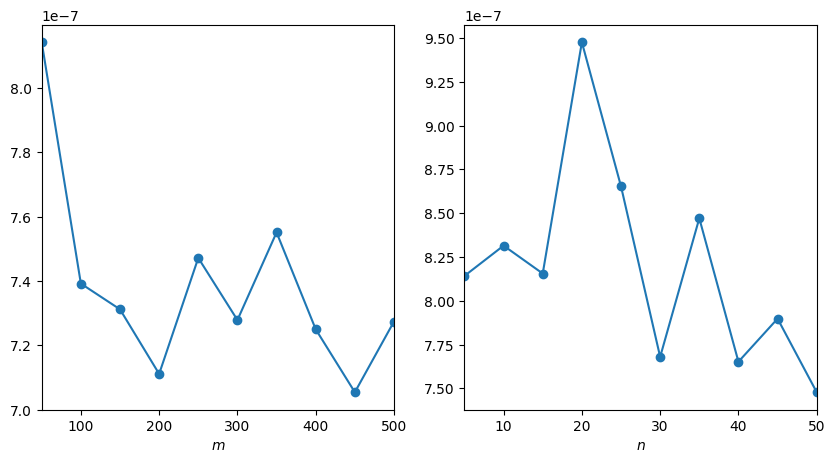

In [10]:
import matplotlib.pyplot as plt

t_bm_mean = [t_bm[(i, ns[0])].average for i in ms]
t_bm_std = [t_bm[(i, ns[0])].stdev for i in ms]
plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(ms, t_bm_mean, marker='o')
plt.xlim(ms[0], ms[-1])
plt.xlabel('$m$')

plt.subplot(1, 2, 2)
t_bm_mean = [t_bm[(ms[0], j)].average for j in ns]
t_bm_std = [t_bm[(ms[0], j)].stdev for j in ns]
plt.plot(ns, t_bm_mean, marker='o')
plt.xlim(ns[0], ns[-1])
plt.xlabel('$n$')

plt.show()

## Numba just-in-time compilation

Using sortednp allows to avoid a slow Python loop for computing the merge intersections (instead using a fast C-loop). However, the close-by-one algorithm still has a nested Python for-loop over attributes. To eliminate this, we can use just-in-time compilation with the numba package. However, this requires a couple of further modifications:

1. We have to convert our Python incidence lists to numba typed lists. Otherwise numba would map our Python lists to untyped reflected lists, which would require the C-loop to inspect every list element and check for its type (removing any speed-up).

2. We have to re-implement the merge intersection, because numba does not support sortednp.

3. We have to eliminate the default arguments for the close-by-one procedure to have fixed-type compilable signatures. There are probably other solutions for this based on advanced numba features.


In [ ]:
# from realkd.search import GreedySearch
# from numba import njit

# @njit
# def count_concepts_sl_numba(ints, exts):
#     pass

In [36]:
from realkd.rules import RuleBoostingEstimator, XGBRuleEstimator, logistic_loss
from realkd.search import search_methods
from numba import njit
import pandas as pd
import sortednp as snp
import doctest

from collections import defaultdict, deque
from sortedcontainers import SortedSet
from math import inf
from heapq import heappop, heappush
from numpy import array
from bitarray import bitarray
import collections.abc

from math import inf
from numpy import arange, argsort, array, cumsum, exp, full_like, log2, stack, zeros, zeros_like
from pandas import qcut, Series
from sklearn.base import BaseEstimator, clone

from realkd.search import Conjunction, Context, KeyValueProposition, Constraint
from bitarray.util import subset

from realkd.logic import Conjunction, Constraint, KeyValueProposition, TabulatedProposition

re = RuleBoostingEstimator(base_learner=XGBRuleEstimator(loss=logistic_loss, search='numba_greedy'))

def build_numba_obj_function(X, y):
    loss = logistic_loss # TODO: Generalize
    reg = 1.0 # TODO: Generalize
    predictions = zeros_like(y) # TODO: Generalize
    g = array(loss.g(y, predictions))
    h = array(loss.h(y, predictions))
    r = g / h
    order = argsort(r)[::-1]
    g = g[order]
    h = h[order]
    n = y.shape[0]

    @njit
    def objective_function(ext):
        if len(ext) == 0:
            return -inf
        g_q = g[ext]
        h_q = h[ext]
        return g_q.sum() ** 2 / (2 * n * (reg + h_q.sum()))
    return objective_function

@njit
def my_intersect(arr1, arr2):
    return np.array(set(arr1).intersection(arr2))

# https://stackoverflow.com/questions/59959207/intersection-of-two-lists-in-numba
@njit()
def JitListComp(l1, l2):
    l3 = np.array([i for i in l1 for j in l2 if i == j])
    return np.unique(l3)

@njit
def find_best_new_index(current_intent, current_extent , extents, initial_value, f, n):
    best_i, best_ext = None, current_extent
    value = initial_value
    for i in range(n):
        if i in current_intent:
            continue
        new_extent = JitListComp(current_extent, extents[i])
        new_value = f(new_extent)
        if new_value > value:
            value = new_value
            best_ext = new_extent
            best_i = i
    return (best_i, best_ext, value)

@njit
def numba_run(extent, n, extents, f):
    """
    Runs the configured search.

    :return: :class:`~realkd.logic.Conjunction` that (approximately) maximizes objective
    """
    intent = [-1]
    value = f(extent)
    while True:
        best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
        if best_i is not None:
            # Update intent and try again
            intent.append(best_i)
            extent = best_ext
            value = new_value
        else:
            # Intent can't get any better
            break
    return intent[1:]

class NumbaGreedySearch:
    def __init__(self, ctx, obj, bdn=None, verbose=False, **kwargs):
        """

        :param Context ctx: the context defining the search space
        :param callable obj: objective function
        :param callable bnd: bounding function satisfying that ``bnd(q) >= max{obj(r) for r in successors(q)}`` (for signature compatibility only, not currently used)
        :param int verbose: level of verbosity

        """
        self.ctx = ctx
        self.f = obj
        self.verbose = verbose

    def run(self):
        """
        Runs the configured search.

        :return: :class:`~realkd.logic.Conjunction` that (approximately) maximizes objective
        """
        # The context is essentially the "current" intent and extent
        # Also note intent implies extent
        # Initially all row indexes from existing extent are selected (i.e intent = [])
        initial_extent = np.array(self.ctx.extension([]))
        n = self.ctx.n
        extents = self.ctx.extents
        attributes = self.ctx.attributes
        # Intent is a list of COLUMN indexes to select by
        intent = numba_run(initial_extent, n, extents, self.f)
        return Conjunction(map(lambda i: attributes[i], intent))




In [37]:
from realkd.search import GreedySearch

def run_search_numba(data):
    objective_function = build_numba_obj_function(data[0], data[1])
    search = NumbaGreedySearch(ctx=Context.from_df(data[0]), obj=objective_function, bdn=None)
    search.run()

def run_search_base(data):
    objective_function = build_numba_obj_function(data[0], data[1])
    search = GreedySearch(ctx=Context.from_df(data[0]), obj=objective_function, bdn=None)
    search.run()

In [38]:
run_search_numba(d[(ms[0],ns[0])])

/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

In [39]:
t_numba = {}
t_base = {}

ms_to_plot = ms
ns_to_plot = ns

for m in ms_to_plot:
    t_numba[(m, ns[0])] = %timeit -o run_search_numba(d[(m, ns[0])])
    t_base[(m, ns[0])] = %timeit -o run_search_base(d[(m, ns[0])])

for n in ns_to_plot:
    t_numba[(ms[0], n)] = %timeit -o run_search_numba(d[(ms[0], n)])
    t_base[(ms[0], n)] = %timeit -o run_search_base(d[(ms[0], n)])

/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

1.91 s ± 82.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
141 ms ± 3.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

1.86 s ± 26.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
143 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

1.87 s ± 75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
147 ms ± 2.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

1.94 s ± 39.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
158 ms ± 2.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

2.14 s ± 198 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
165 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

1.98 s ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
187 ms ± 34.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

2.24 s ± 361 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
170 ms ± 7.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

2.32 s ± 391 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
248 ms ± 20.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

2.47 s ± 262 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
233 ms ± 45.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

1.95 s ± 46.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
183 ms ± 2.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

2.52 s ± 455 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
185 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

2.39 s ± 404 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
198 ms ± 48.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

2.24 s ± 335 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
150 ms ± 2.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

2.02 s ± 50.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
153 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

3.08 s ± 1.01 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
239 ms ± 18.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

2.51 s ± 311 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
209 ms ± 6.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

2.53 s ± 46.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
216 ms ± 7.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

2.53 s ± 96.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
218 ms ± 6.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

2.13 s ± 304 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
200 ms ± 24.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/tmp/ipykernel_11983/1774158704.py:84: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'find_best_new_index'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../tmp/ipykernel_11983/1774158704.py", line 59:
<source missing, REPL/exec in use?>

  best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, f, n)
/home/alastair/personal/rawork/realkd.py/ra-venv/lib/python3.8/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extents' of function 'numba_run'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../.

2.16 s ± 72.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
172 ms ± 4.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


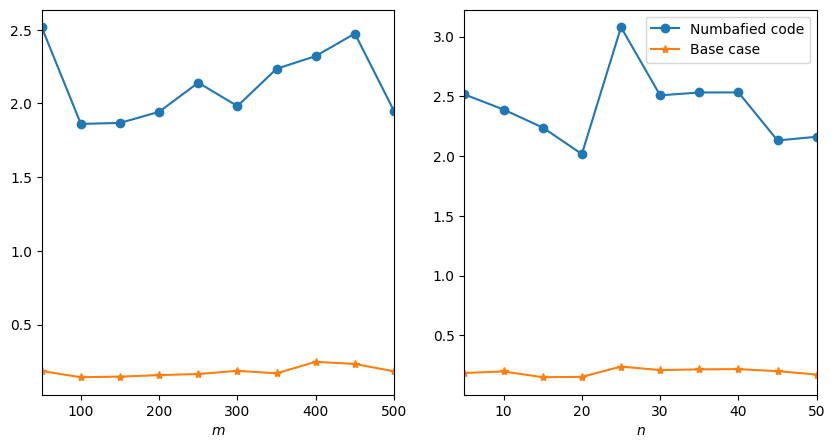

In [40]:
plt.subplots(1, 2, figsize=(10, 5))

t_numba_mean = [t_numba[(m, ns[0])].average for m in ms_to_plot]
t_numba_std = [t_numba[(m, ns[0])].stdev for m in ms_to_plot]
t_base_mean = [t_base[(m, ns[0])].average for m in ms_to_plot]
t_base_std = [t_base[(m, ns[0])].stdev for m in ms_to_plot]

plt.subplot(1, 2, 1)
plt.plot(ms_to_plot, t_numba_mean, marker='o')
plt.plot(ms_to_plot, t_base_mean, marker='*')
plt.xlim(ms_to_plot[0], ms_to_plot[-1])
plt.xlabel('$m$')

t_numba_mean = [t_numba[(ms[0], n)].average for n in ns_to_plot]
t_numba_std = [t_numba[(ms[0], n)].stdev for n in ns_to_plot]
t_base_mean = [t_base[(ms[0], n)].average for n in ns_to_plot]
t_base_std = [t_base[(ms[0], n)].stdev for n in ns_to_plot]

plt.subplot(1, 2, 2)
plt.plot(ns_to_plot, t_numba_mean, marker='o', label='Numbafied code')
plt.plot(ns_to_plot, t_base_mean, marker='*', label='Base case')
plt.xlim(ns_to_plot[0], ns_to_plot[-1])
plt.xlabel('$n$')
plt.legend()

plt.show()